#Turntable calibration

In this article is presented a method to determine the homogeneus transformation between the camera coordinate system and the rotation center of the turntable. ![](https://raw.githubusercontent.com/Jesus89/3DScanScience/master/notebooks/images/4.4.%20Laser%20calibration/pattern-position.png)

##Capture pattern origin

Pattern is automatically moved on the turntable from -90º to 90º respect to the initial position. Each step (5º) it is captured the [pattern's pose](http://nbviewer.ipython.org/github/Jesus89/3DScanScience/blob/master/notebooks/4.1.%20Pattern%20detection.ipynb). Using $[R,\textbf{t}]$ (pattern pose), $r$ (pattern's rows) and $sw$ (pattern's square width) can be computed $\textbf{p}$, the pattern origin point, defined as the bottom-left corner.

$$
\textbf{p} = \textbf{t} + R · \begin{bmatrix} 0 \\ (r - 1) · sw \\ 0 \\ \end{bmatrix}
$$

In [1]:
import numpy as np

#Load example points
points = np.array([(-71.889508465627387, 50.013567717607749, 344.49352456998758), (-73.938146681112755, 50.246193674080907, 338.01301804172272), (-75.497351387650639, 50.492948734714403, 330.87542127925065), (-76.376380847308425, 50.734117933168591, 324.17522165185346), (-76.714488167787607, 50.993900582296561, 317.3344047282414), (-76.403768361627812, 51.272234507372353, 309.71864906038684), (-75.485306621272557, 51.549433425353058, 302.68961151070874), (-74.000231775386524, 51.809640767591226, 295.94087917913839), (-71.835845971537935, 52.082778636253131, 289.01220924464218), (-69.311034379453886, 52.328053219713709, 282.87092458439184), (-65.822041224968615, 52.625688337478778, 276.18480478407253), (-62.336253545911951, 52.877250167738936, 270.66679623202765), (-58.041963526078746, 53.137164118260294, 264.97985913318598), (-53.181565932121643, 53.376856358245568, 259.6388616558591), (-48.270518476370661, 53.582888438128002, 255.0205618040097), (-42.173702942476567, 53.798821993651814, 250.33223366723669), (-36.54320409745096, 53.975402416771956, 246.74779748678947), (-30.470855853767048, 54.130827402058607, 243.45798455002659), (-23.565546697472435, 54.289427296325343, 240.58263365325183), (-17.031816562984559, 54.410496232507043, 238.44783394220926), (-10.000560702649052, 54.524867785168766, 236.84255161321303), (-3.024878053643687, 54.612931136574318, 235.84493023779947), (4.1151465080711507, 54.678828047877047, 235.49675611700954), (11.189306930064157, 54.717826806420923, 235.76911469780327)])

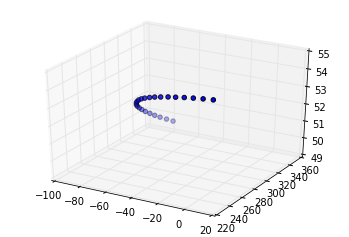

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot points
fig = plt.figure()
ax = fig.gca(projection = '3d')
X, Y, Z = points.T[0], points.T[1], points.T[2]
ax.scatter(X, Z, Y)
plt.show()

##Fit plane
In this section it is computed the best plane defined by the points using Least squares method.

In [3]:
from scipy import optimize

def distance2plane(p0, n0, p):
    return np.dot(np.array(n0), np.array(p) - np.array(p0))

def residuals_plane(parameters, data_point):
    px, py, pz, theta, phi = parameters
    nx, ny, nz = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)
    distances = [distance2plane([px, py, pz], [nx, ny, nz], [x, y, z]) for x, y, z in data_point]
    return distances

def fit_plane(data):
    estimate = [0, 0, 0, 0, 0]  # px, py, pz and zeta, phi
    best_fit_values, ier = optimize.leastsq(residuals_plane, estimate, args=(data))
    xF, yF, zF, tF, pF = best_fit_values
    #point  = [xF, yF, zF]
    point = data[0]
    normal = -np.array([np.sin(tF) * np.cos(pF), np.sin(tF) * np.sin(pF), np.cos(tF)])
    return point, normal

point, normal = fit_plane(points)

if normal[1] > 0:
    normal *= -1

print("\nPlane normal\n\n{0}\n".format(normal))


Plane normal

[ 0.0072119  -0.99925488 -0.03791666]



##Fit circle
In this section it is computed the best circle contained in the plane, defined by the points using Least squares method.

In [4]:
def residuals_circle(parameters, points, s, r, point):
    r_, s_, Ri = parameters
    plane_point = s_ * s + r_ * r + np.array(point)
    distance = [np.linalg.norm(plane_point - np.array([x, y, z])) for x, y, z in points]
    res = [(Ri - dist) for dist in distance]
    return res

def fit_circle(point, normal, points):
    s = np.cross(np.array([1, 0, 0]), np.array(normal))
    s = s / np.linalg.norm(s)
    r = np.cross(np.array(normal), s)
    r = r / np.linalg.norm(r)

    # Define rotation
    R = np.array([s, r, normal]).T

    estimate_circle = [0, 0, 0]  # px,py,pz and zeta, phi
    best_circle_fit_values, ier = optimize.leastsq(residuals_circle, estimate_circle, args=(points, s, r, point))
    rF, sF, RiF = best_circle_fit_values

    # Synthetic Data
    center_point = sF * s + rF * r + np.array(point)
    synthetic = [list(center_point + RiF * np.cos(phi) * r + RiF * np.sin(phi) * s)
                 for phi in np.linspace(0, 2 * np.pi, 50)]

    return center_point, R

center, R = fit_circle(point, normal, points)

##Homogeneous transformation

The homogeneous transformation matrix of the turntable is defined by $R$, rotation matrix obtained from the plane's normal, and $\textbf{t}$, computed by using the center of the circle, the plane's normal and the pattern origin distance. This last value has to be measured in real world, in order to determine the coordinate system on the platform.
![](https://raw.githubusercontent.com/Jesus89/3DScanScience/master/notebooks/images/4.5.%20Turntable%20calibration/pattern-origin-distance.jpg)

In [5]:
X = 37.2

t = center - X * np.array(normal)

print("\nRotation matrix\n\n{0}\n".format(R))
print("\nTranslation vector\n\n{0} mm\n".format(t))


Rotation matrix

[[  0.00000000e+00   9.99973994e-01   7.21190061e-03]
 [  3.79176484e-02   7.20671429e-03  -9.99254880e-01]
 [ -9.99280867e-01   2.73458311e-04  -3.79166623e-02]]


Translation vector

[   4.42701066   88.78675021  318.28065121] mm



#References